In [40]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.patches import Patch
import textwrap


def get_key(ymdb_id, k, tsv_dir):
    in_file = os.path.join(tsv_dir, f"{ymdb_id}.tsv")
    with open(in_file, 'r') as f:
        for line in f.readlines():
            line = line.split('\t')
            if line[0] == k:
                return(';'.join(line[1 : ]).strip())
    sys.exit(f'Error - couldnt find key {k} in {ymdb_id}.tsv')

def read_data(positive_metabolite_path, negative_metabolite_path):
    positive_df = pd.read_csv(positive_metabolite_path)
    negative_df = pd.read_csv(negative_metabolite_path)
    return positive_df, negative_df

def normalize_intensities(data, method):
    if method == 'total_ion_current_area':
        data['Normalized_Area'] = data['Area'] / data['Total Ion Current Area']
    elif method == 'subtract_wash_intensity':
        wash_mean_areas = data[data['Replicate Name'].str.contains('WASH')].groupby('Molecule Name')['Area'].mean().reset_index()
        data = data.merge(wash_mean_areas, on='Molecule Name', suffixes=('_metabolite', '_wash'))
        data['Subtracted_Area'] = data['Area_metabolite'] - data['Area_wash']
        data['Normalized_Area'] = data['Subtracted_Area'] / data['Total Ion Current Area']
    elif method == 'pqn':
        # Calculate the median spectrum
        median_spectrum = data.groupby('Molecule Name')['Area'].median().reset_index()
        
        # Compute the scaling factors for each sample
        data_with_scaling_factors = data.merge(median_spectrum, on='Molecule Name', suffixes=('', '_median'))
        data_with_scaling_factors['Scaling_Factor'] = data_with_scaling_factors['Area'] / data_with_scaling_factors['Area_median']
        
        # Calculate the median scaling factor for each sample
        median_scaling_factors = data_with_scaling_factors.groupby('Replicate Name')['Scaling_Factor'].median().reset_index()
        
        # Normalize each sample by dividing the intensity of each peak by the corresponding median scaling factor
        data = data.merge(median_scaling_factors, on='Replicate Name')
        data['Normalized_Area'] = data['Area'] / data['Scaling_Factor']
    else:
        sys.exit(f'Unrecognized normalization method {method}')
    return data



def filter_and_normalize(positive_df, negative_df, normalization_method):
    # Filter out the relevant columns
    positive_filtered = positive_df[['Molecule Name', 'Replicate Name', 'Area', 'Total Ion Current Area']].dropna(subset=['Replicate Name'])
    negative_filtered = negative_df[['Molecule Name', 'Replicate Name', 'Area', 'Total Ion Current Area']].dropna(subset=['Replicate Name'])

    positive_filtered["Mode"] = "Positive"
    negative_filtered["Mode"] = "Negative"


    # Normalize intensities
    positive_filtered = normalize_intensities(positive_filtered, normalization_method)
    negative_filtered = normalize_intensities(negative_filtered, normalization_method)

    return positive_filtered, negative_filtered

# Map metabolite names to colors based on their Super Class
def remove_peak_name(s):
    s_out = '-'.join(s.split('-')[ : -1])
    return(s_out)


def preprocess_data(positive_filtered, negative_filtered, name_to_super_class):
    # Remove positive replicates greater than 12
    positive_filtered['Replicate_num'] = positive_filtered['Replicate Name'].str.extract('(\d+)$').astype(int)
    positive_filtered = positive_filtered[positive_filtered['Replicate_num'] <= 12]

    # Calculate average normalized intensities for each metabolite in positive and negative mode (excluding washes)
    positive_no_washes = positive_filtered[~positive_filtered['Replicate Name'].str.contains('WASH')]
    negative_no_washes = negative_filtered[~negative_filtered['Replicate Name'].str.contains('WASH')]

    positive_mean_normalized_areas = positive_no_washes.groupby('Molecule Name')['Normalized_Area'].mean().reset_index()
    negative_mean_normalized_areas = negative_no_washes.groupby('Molecule Name')['Normalized_Area'].mean().reset_index()

    positive_mean_normalized_areas['Mode'] = 'Positive'
    negative_mean_normalized_areas['Mode'] = 'Negative'

    normalized_areas = pd.concat([positive_mean_normalized_areas, negative_mean_normalized_areas], ignore_index=True)
    normalized_areas = normalized_areas.fillna(value = 0.0)

    # Map metabolite names to super classes
    normalized_areas['Super Class'] = normalized_areas['Molecule Name'].map(lambda x : name_to_super_class[remove_peak_name(x)])

    return (normalized_areas, positive_no_washes, negative_no_washes)

def plot_normalized_areas(normalized_areas):
    # fig, ax = plt.figure(figsize=(16, 8))
    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(data=normalized_areas, x='Super Class', y='Normalized_Area', hue='Mode', palette='pastel')
    swarm = sns.stripplot(data=normalized_areas, x='Super Class', y='Normalized_Area', hue='Mode', dodge=True, size=4, edgecolor='gray', linewidth=0.5, alpha=0.7)
    plt.yscale("log")


    # plt.xticks(rotation=90)
    # Rotate the x-axis labels and wrap their text
    labels = [textwrap.fill(label.get_text(), width=14) for label in ax.get_xticklabels()]
    plt.xticks(rotation=45, ha='right')  # rotation of 45 degrees, aligned right
    ax.set_xticklabels(labels)




    plt.xlabel('Super Class')
    plt.ylabel('Normalized Area')
    plt.title('Distribution of Normalized Areas per Metabolite Class')
    handles, labels = swarm.get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Mode')
    return(fig, ax)
    # plt.show()

def plot_catplot(normalized_areas):
    # Compute the mean normalized area for each molecule name and super class
    aggregated_data = normalized_areas.groupby(['Molecule Name', 'Super Class', 'Mode'])['Normalized_Area'].mean().reset_index()

    # Sort the data based on average intensity across modes within the same super class
    aggregated_data['sort_val'] = aggregated_data.groupby(['Molecule Name', 'Super Class'])['Normalized_Area'].transform('mean')
    aggregated_data = aggregated_data.sort_values(['Super Class', 'sort_val'], ascending=[True, False])

    g = sns.FacetGrid(aggregated_data, col='Super Class', hue='Mode', col_wrap=4, sharex=True, sharey=False, height=8, aspect=1, palette='pastel')

    # Get the order of Molecule Names for each Super Class
    order_dict = aggregated_data.groupby('Super Class')['Molecule Name'].apply(list).to_dict()
    order_dict = {k : list(order_dict.fromkeys(v)) for (k, v) in order_dict.items()}
    

    def plot_bars(x, y, **kwargs):
        ax = plt.gca()
        order = order_dict[ax.get_title().split(' = ')[-1]]
        sns.barplot(x=x, y=y, order=order, dodge=False, edgecolor='gray', linewidth=0.5, alpha=0.7, **kwargs)

    g.map_dataframe(plot_bars, x='Normalized_Area', y='Molecule Name')
    g.set_axis_labels('Normalized_Area', 'Molecule Name', fontsize=16)
    g.set_titles(col_template="{col_name}", size = 20)
    g.set_xticklabels(rotation=90)
    g.fig.subplots_adjust(wspace=.6, hspace=.2)
    g.set(xscale="log")

    # Adjust the legend issue
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_size(16)
        if ax.legend_:
            ax.legend_.remove()

    # Create a single legend for the entire plot
    handles = g.axes.flat[0].get_legend_handles_labels()[0]
    labels = g.axes.flat[0].get_legend_handles_labels()[1]
    g.fig.legend(handles=handles, labels=labels, loc = "center left", title='Mode', fontsize=16, title_fontsize = 16)
    return(g)
    # if filename:
        # plt.savefig(filename, bbox_inches = 'tight')
    # plt.show()


def plot_heatmap(combined_no_washes, name_to_super_class, super_class_to_color, filter_metabs = None):
    if filter_metabs:
        combined_no_washes = combined_no_washes[combined_no_washes['Molecule Name'].isin(filter_metabs)]
    heatmap_data = combined_no_washes.pivot_table(index='Molecule Name', columns=['Mode', 'Replicate Name'], values='Normalized_Area')
    heatmap_data = heatmap_data.fillna(value = 0.0)

    label_colors = heatmap_data.index.map(lambda x: name_to_super_class[remove_peak_name(x)]).map(super_class_to_color)
    fig, ax = plt.subplots(figsize=(25, 15))
    sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt='.2f', annot_kws={'size': 8}, cbar_kws={'label': 'Normalized Intensity'}, ax=ax)

    # Color the y-axis labels according to super class
    ax.set_yticks(range(len(heatmap_data.index)))
    ax.set_yticklabels([])
    for i, label in enumerate(heatmap_data.index):
        molecule_name = label
        color = super_class_to_color[name_to_super_class[remove_peak_name(molecule_name)]]
        ax.text(-0.5, i, molecule_name, ha='right', va='center', fontsize=8, bbox=dict(facecolor=color, edgecolor='none', alpha=0.3, pad=0))

    # Create a legend
    legend_patches = [Patch(facecolor=color, edgecolor='none', alpha=0.3, label=super_class) for super_class, color in super_class_to_color.items()]
    fig.legend(handles=legend_patches, title="Metabolite Class")

    plt.title('Per-replicate normalized intensity in positive and negative mode')
    num_negative_replicates = len(negative_no_washes['Replicate Name'].unique())
    plt.axvline(x=num_negative_replicates, color='red', linestyle='--')
    return(fig, ax)
    plt.show()

100%|██████████| 263/263 [00:00<00:00, 2467.28it/s]


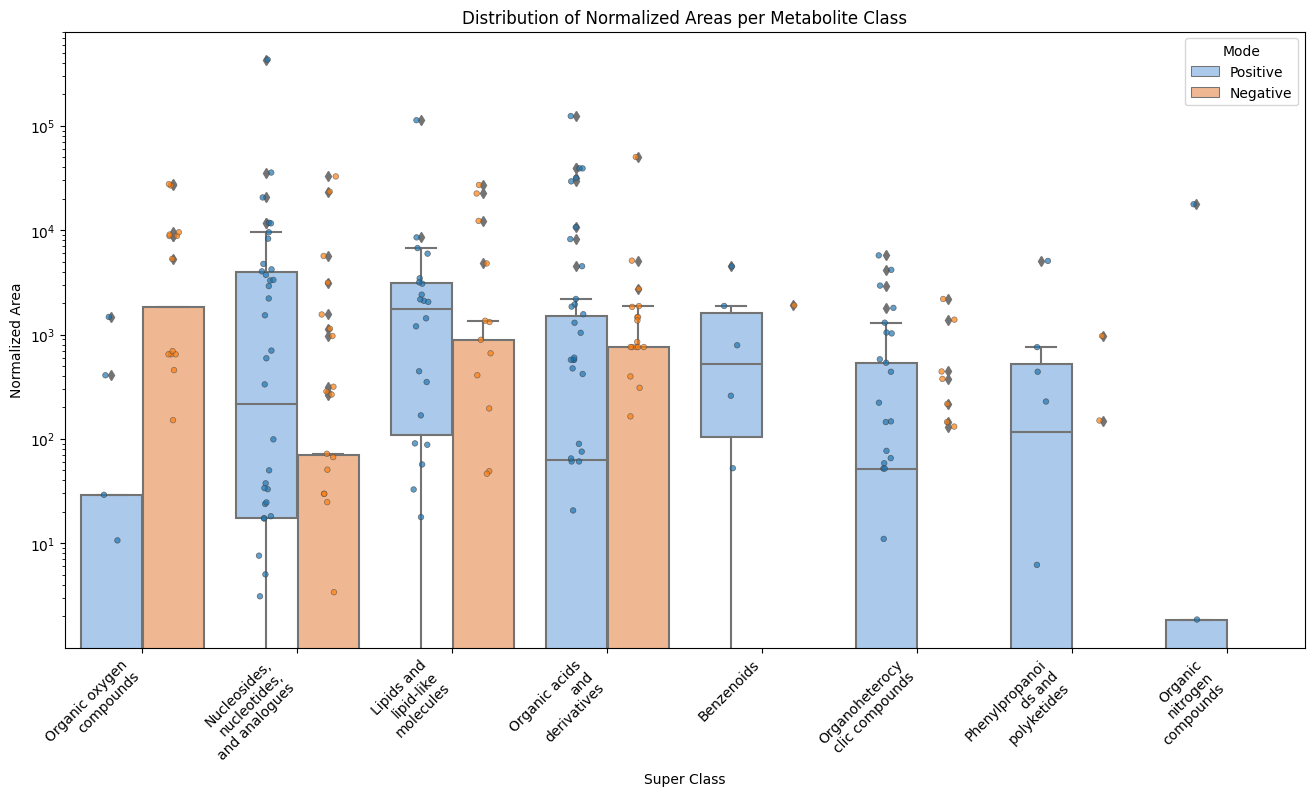

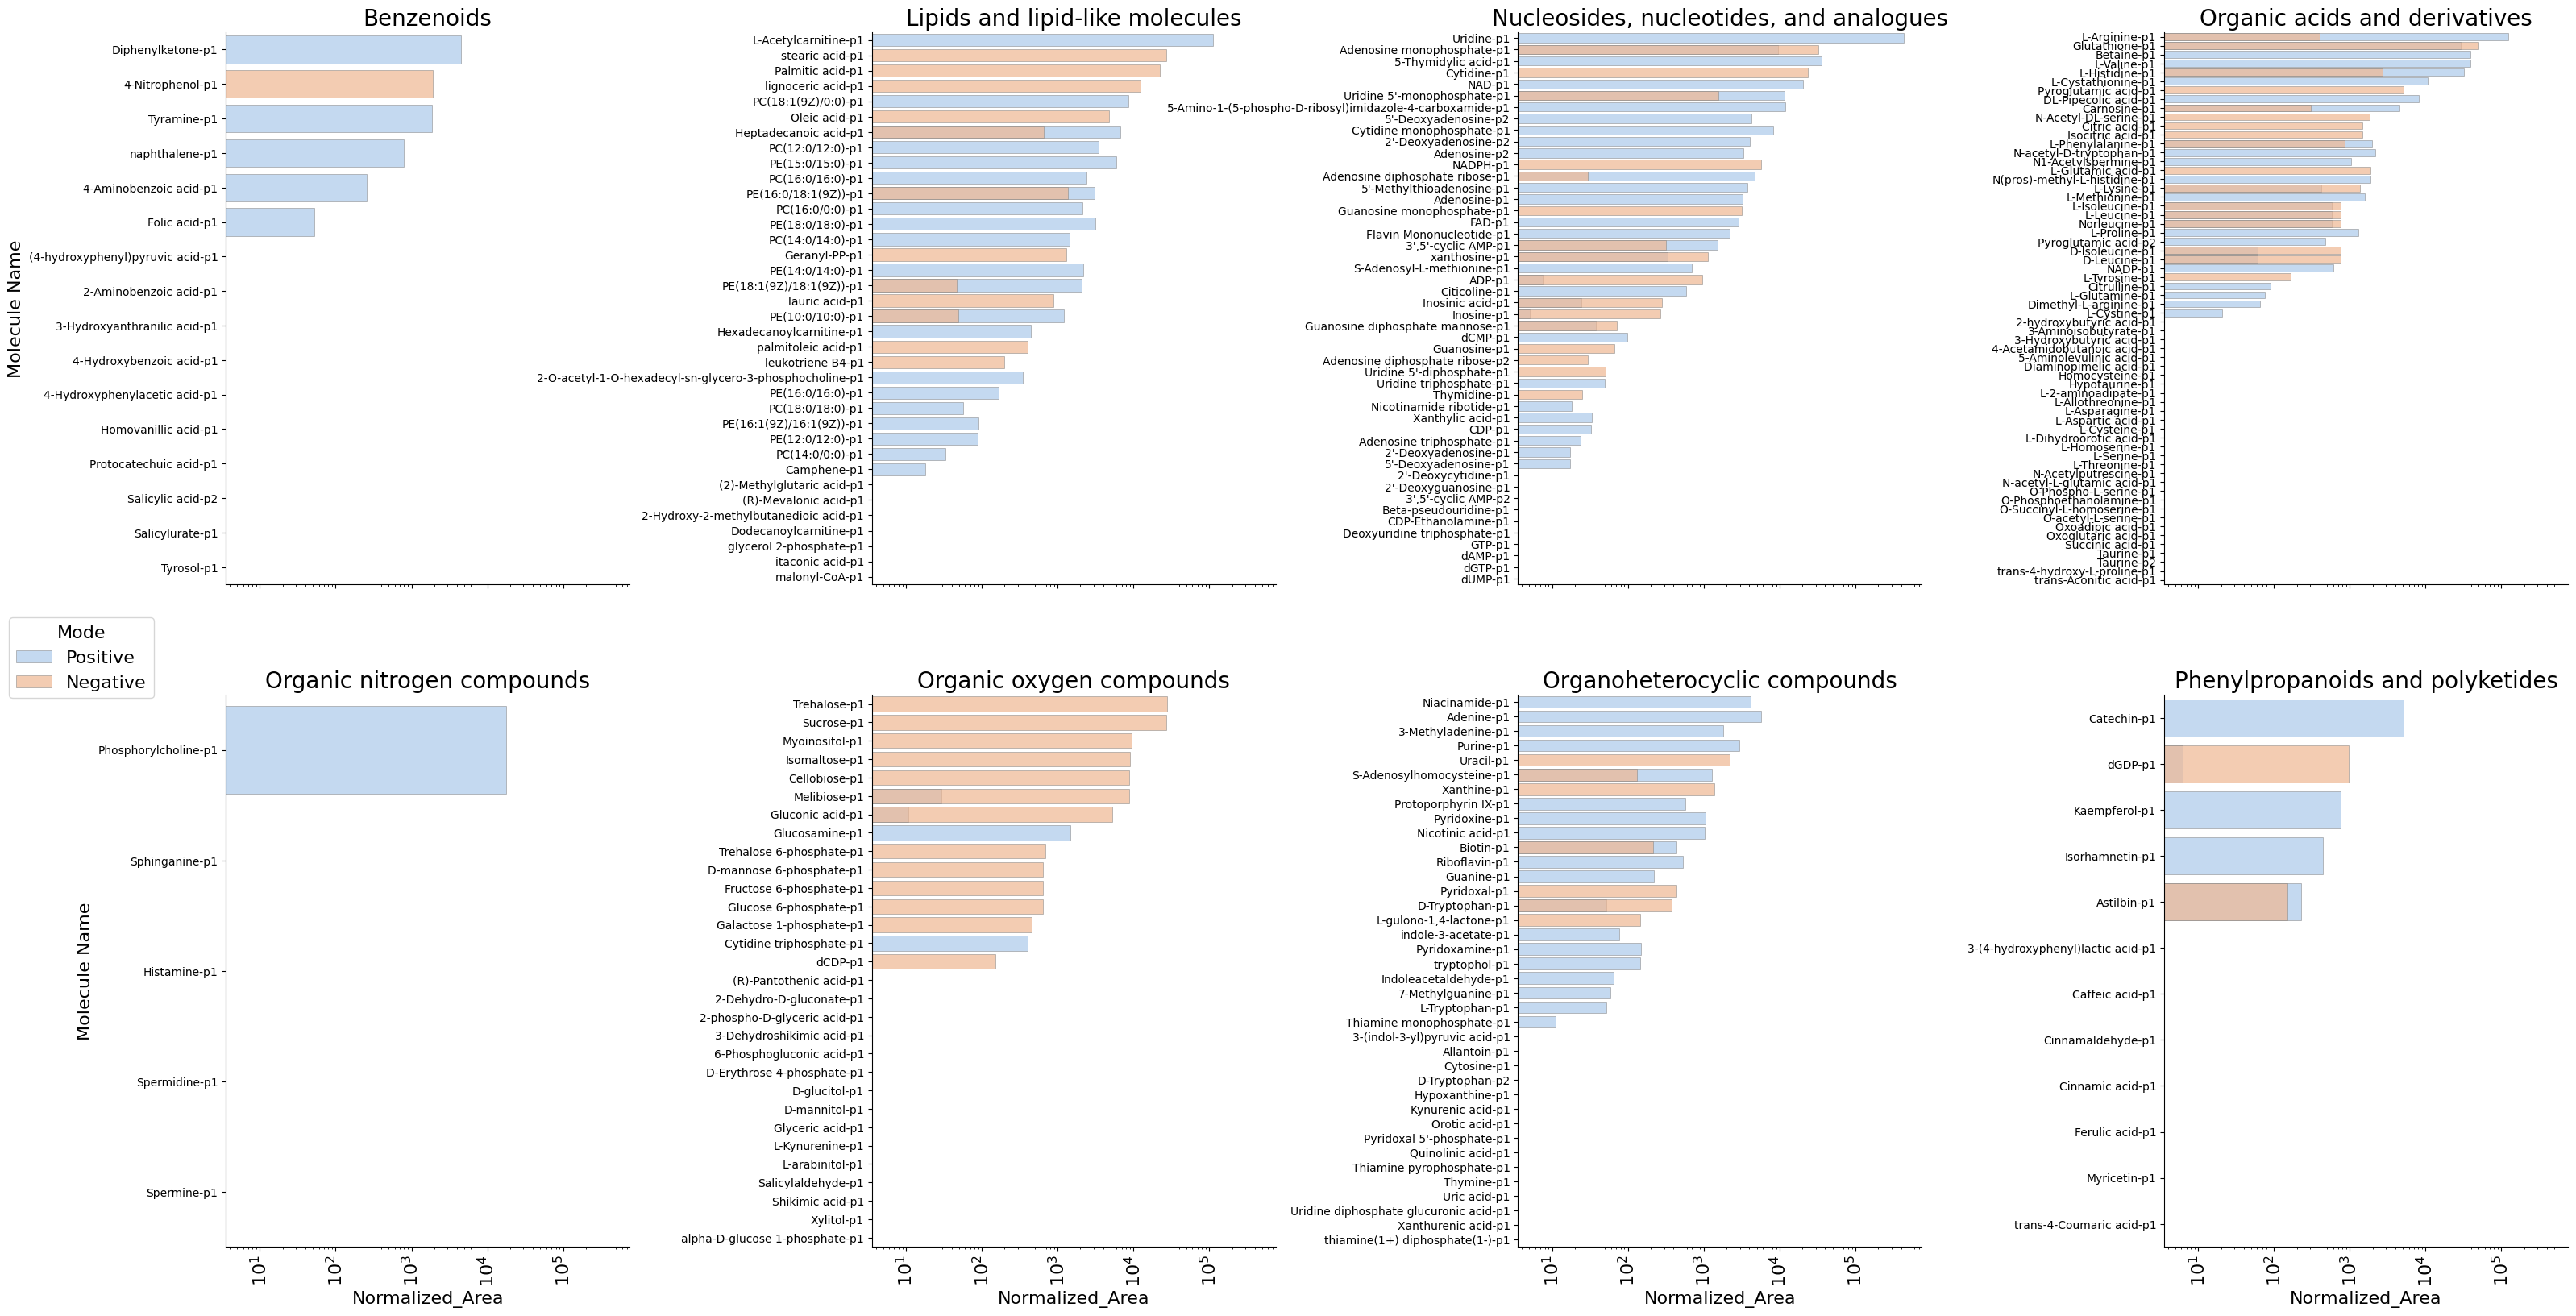

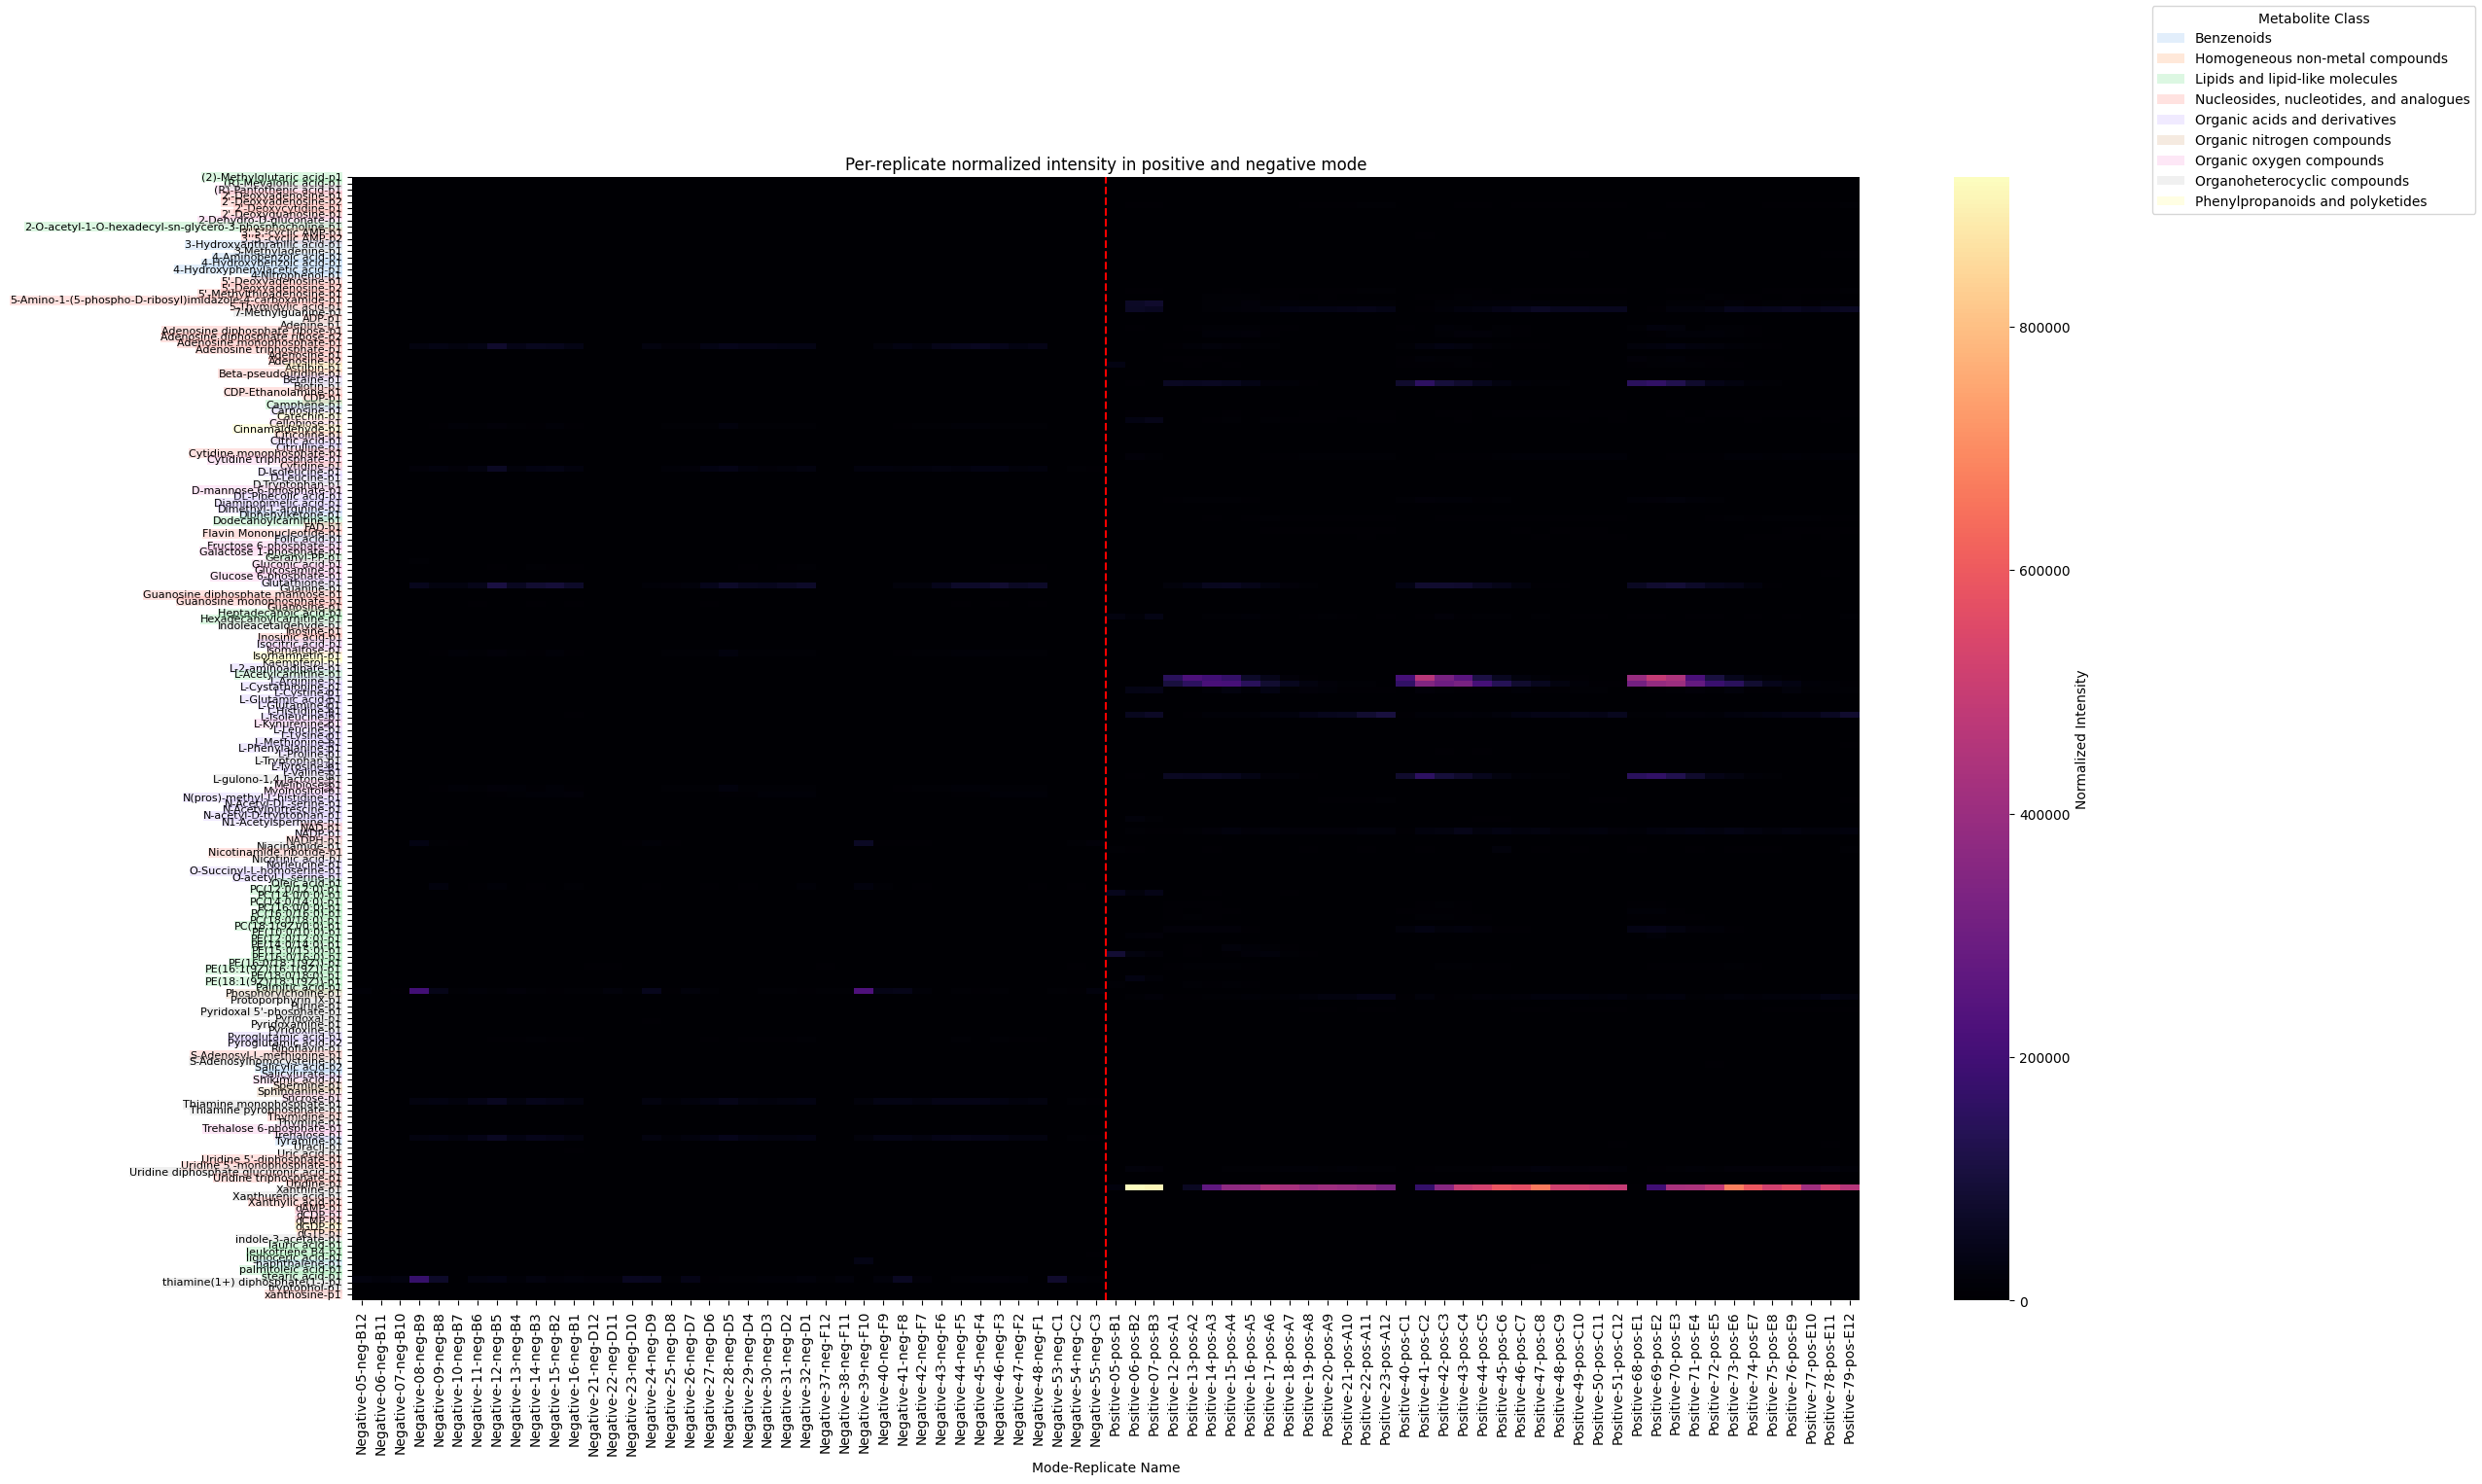

In [41]:
top_dir = "/Users/reder/OneDrive/right-bourbon/pilot_yeast_ymdb"
positive_metabolite_path = '/Users/reder/OneDrive/right-bourbon/002_ymdb_pos/out_files/MetaboliteReportShort.csv'
negative_metabolite_path = '/Users/reder/OneDrive/right-bourbon/002_ymdb_neg/out_files/MetaboliteReportShort.csv'
tsv_dir = os.path.join(top_dir, "tsvs")
df_in = pd.read_csv(os.path.join(top_dir, "ymdb_ids.tsv"), sep = '\t')

name_to_super_class = {}
for name, ymdb_id in tqdm(df_in[['NAME', 'ymdb_id']].values):
    # if ymdb_id.endswith('.tsv'):
        # ymdb_id_stripped = ymdb_id.split('.')[0]
    super_class = get_key(ymdb_id, 'Super Class', tsv_dir)
    name_to_super_class[name] = super_class

# Choose the normalization method ('total_ion_current_area' or 'subtract_wash_intensity' or 'pqn')
# normalization_method = 'total_ion_current_area'
# normalization_method = "subtract_wash_intensity"
normalization_method = "pqn"

# Read data
positive_df, negative_df = read_data(positive_metabolite_path, negative_metabolite_path)

# Filter and normalize data
positive_filtered, negative_filtered = filter_and_normalize(positive_df, negative_df, normalization_method)

# Preprocess data
normalized_areas, positive_no_washes, negative_no_washes = preprocess_data(positive_filtered, negative_filtered, name_to_super_class)

# Plot data
fig, ax = plot_normalized_areas(normalized_areas)
plt.savefig("/Users/reder/OneDrive/right-bourbon/pilot_yeast/normalized_areas.svg", bbox_inches = 'tight')
plt.show()


g = plot_catplot(normalized_areas)
plt.savefig("/Users/reder/OneDrive/right-bourbon/pilot_yeast/catplot.svg", bbox_inches = 'tight')
plt.show()
# , filename = None

combined_no_washes = pd.concat([positive_no_washes, negative_no_washes], ignore_index=True)
combined_no_washes['Well'] = [x.split('-')[-1] for x in combined_no_washes['Replicate Name']]
unique_super_classes = sorted(set(name_to_super_class.values()))
palette = sns.color_palette("pastel", len(unique_super_classes))
super_class_to_color = {super_class: color for super_class, color in zip(unique_super_classes, palette)}

fig, ax = plot_heatmap(combined_no_washes, name_to_super_class, super_class_to_color)
plt.savefig("/Users/reder/OneDrive/right-bourbon/pilot_yeast/heatmap.svg", bbox_inches = 'tight')
plt.show()

## Tests for picking out best metabolites

In [115]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def select_top_metabolites(data, wells, replicate_prefixes, n_top=30, int_thresh=1E1, target_metabolites=None):
    return(None)

def select_k_means(data, **kwargs):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)


    # Find the optimal number of clusters using the elbow method
    sse = []
    cluster_range = range(1, 11)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        sse.append(kmeans.inertia_)

    # Find the elbow point
    if "k" in kwargs.keys():
        optimal_k = kwargs['k']
    else:
        knee_locator = KneeLocator(range(1, len(sse) + 1), sse, curve="convex", direction="decreasing")
        optimal_k = knee_locator.elbow


    print(f"The optimal number of clusters (elbow point) is: {optimal_k}")

    # Plot the elbow curve
    plt.plot(cluster_range, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('K-means SSE per clustering')
    plt.axvline(x = optimal_k, linestyle = '--', color = 'k', alpha = 0.5, label = f'Selected k = {optimal_k}')
    plt.legend()
    plt.show()


    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)

    # Add the cluster labels to the original heatmap_data DataFrame
    data_clustered = data.copy()
    data_clustered["Cluster"] = clusters

    # Create a DataFrame with the molecule names and their corresponding cluster labels
    metabolite_clusters = pd.DataFrame({'Molecule Name': data_clustered.index, 'Cluster': data_clustered['Cluster']}).reset_index(drop = True)

    drop_cluster_number = metabolite_clusters.groupby('Cluster').size().sort_values(ascending=False).index[0]
    found_metabolites = metabolite_clusters[metabolite_clusters['Cluster'] != drop_cluster_number]['Molecule Name'].values
    return(found_metabolites)

# def select_intensity(data):

def select_db_scan(data):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Create a DBSCAN clustering model
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    # Fit the model to your scaled data
    dbscan.fit(scaled_data)
    # Count the number of elements in each cluster (cluster labels are stored in 'dbscan.labels_')
    cluster_counts = Counter(dbscan.labels_)
    # Find the label of the largest cluster
    largest_cluster_label = max(cluster_counts, key=cluster_counts.get)
    # Find the indices of the metabolites that do not belong to the largest cluster
    non_largest_cluster_indices = [i for i, label in enumerate(dbscan.labels_) if label != largest_cluster_label]
    # Filter out the metabolites that do not belong to the largest cluster
    # filtered_metabolites = heatmap_data.iloc[non_largest_cluster_indices, :]
    return()
    

def select_metabolites(data, method, **kwargs):
    if "wells" in kwargs.keys():
        wells = kwargs['wells']
        data = data[data['Well'].isin(wells)]
        
    search_data = data.pivot_table(index='Molecule Name', columns=['Mode', 'Replicate Name'], values='Normalized_Area')
    search_data = search_data.fillna(value = 0.0)
    if method == "k-means":
        found_metabolites = select_k_means(search_data, **kwargs)
    elif method == "intensity":
        found_metabolites = select_intensity(search_data, **kwargs)
        
    
    return(found_metabolites)
    


def plot_normalized_intensities(data, wells, metabolite_names, mode, normalize_max = False, log = True):
    data_filtered = data[data["Molecule Name"].isin(metabolite_names)]
    data_filtered = data_filtered[data_filtered["Replicate Name"].str.endswith(tuple(f"-{well}" for well in wells))]
    

    # Calculate the mean intensity for each metabolite across replicates
    data_mean = data_filtered.groupby(["Molecule Name", "Replicate Name"])["Normalized_Area"].mean().reset_index()

    # Normalize the intensity values
    max_intensity = data_mean.groupby("Molecule Name")["Normalized_Area"].max().reset_index(name="Max_Intensity")
    data_mean = data_mean.merge(max_intensity, on="Molecule Name")
    if normalize_max:
        data_mean["Normalized_Intensity"] = data_mean["Normalized_Area"] / data_mean["Max_Intensity"]
    else:
        data_mean["Normalized_Intensity"] = data_mean["Normalized_Area"] # gkreder remember, I got rid of normalization here

    # Calculate the mean and standard error of the mean for each well and metabolite
    data_mean["Well"] = data_mean["Replicate Name"].str.split('-').str[-1]
    data_mean['Injection'] = data_mean["Well"].str.extract('(\d+)', expand=False).astype(int)
    data_summary = data_mean.groupby(["Molecule Name", "Injection"]).agg({"Normalized_Intensity": [np.mean, np.std, "count"]}).reset_index()
    data_summary.columns = ["Molecule Name", "Injection", "Mean_Intensity", "Std_Intensity", "Count"]
    data_summary["SEM_Intensity"] = data_summary["Std_Intensity"] / np.sqrt(data_summary["Count"])

    plt.figure(figsize=(12, 6))
    # sns.lineplot(data=data_summary, x="Injection", y="Mean_Intensity", hue="Molecule Name", marker="o", linewidth=2, yerr=data_summary["SEM_Intensity"])
    sns.lineplot(data=data_summary, x="Injection", y="Mean_Intensity", hue="Molecule Name", marker="o", linewidth=2, errorbar='sd')
    # sns.lineplot(data=data_summary, x="Injection", y="Mean_Intensity", hue="Molecule Name", marker="o", linewidth=2)
    plt.title(f"Metabolite Intensities in {mode} Mode")
    plt.xlabel("Injection")
    if normalize_max:
        sl = "Max-Normalized Intensity"
    else:
        sl = "Normalized Intensity"
    plt.ylabel(sl)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if log:
        plt.yscale("log")
    plt.show()
    return(data_summary)

def plot_single_metab(data, wells, metab_name, mode):
    dfp = pd.DataFrame({"Molecule Name" : [metab_name]})
    data_summary = plot_normalized_intensities(data, wells, dfp, mode)
    return(data_summary)

# target_metabolites = ["L-Arginine-p1", "Glutathione-p1"]
# top_metabolites = select_top_metabolites(positive_no_washes, wells, replicate_prefixes_positive, n_top=30, target_metabolites=target_metabolites)


In [116]:
# # # Define the lists of well names for positive and negative mode injections
# # wells = [f"{i}" for i in range(1, 13)]

# # replicate_prefixes_positive = ["A"]
# # replicate_prefixes_negative = ["B"]

# target_metabolites = ['Glutathione-p1', 'L-Arginine-p1']
injections = [f"{i}" for i in range(1, 13)]
replicate_prefixes_positive = ["A", "C", "E"]
replicate_prefixes_negative = ["B", "D", "F"]
positive_all_wells = [f"{pref}{i}" for pref in replicate_prefixes_positive for i in injections]
negative_all_wells = [f"{pref}{i}" for pref in replicate_prefixes_negative for i in injections]
A_wells = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
B_wells = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']
positive_wells = ['A8', 'A9', 'A10', 'A11']

The optimal number of clusters (elbow point) is: 10


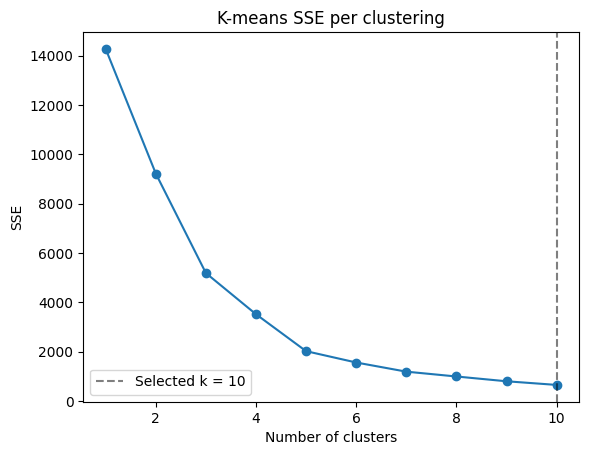

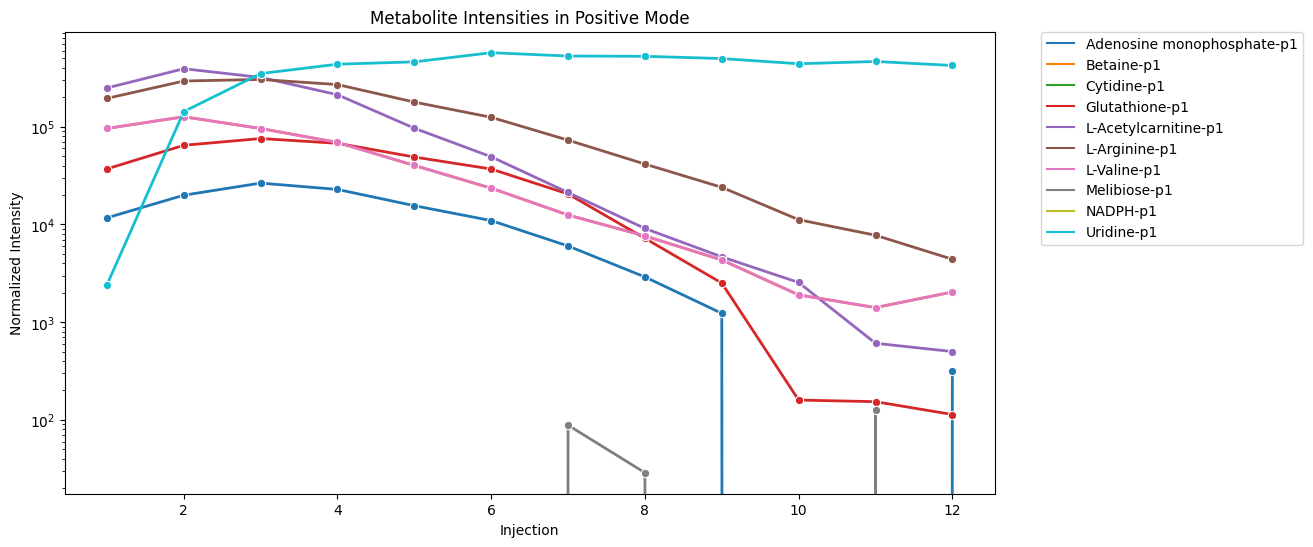

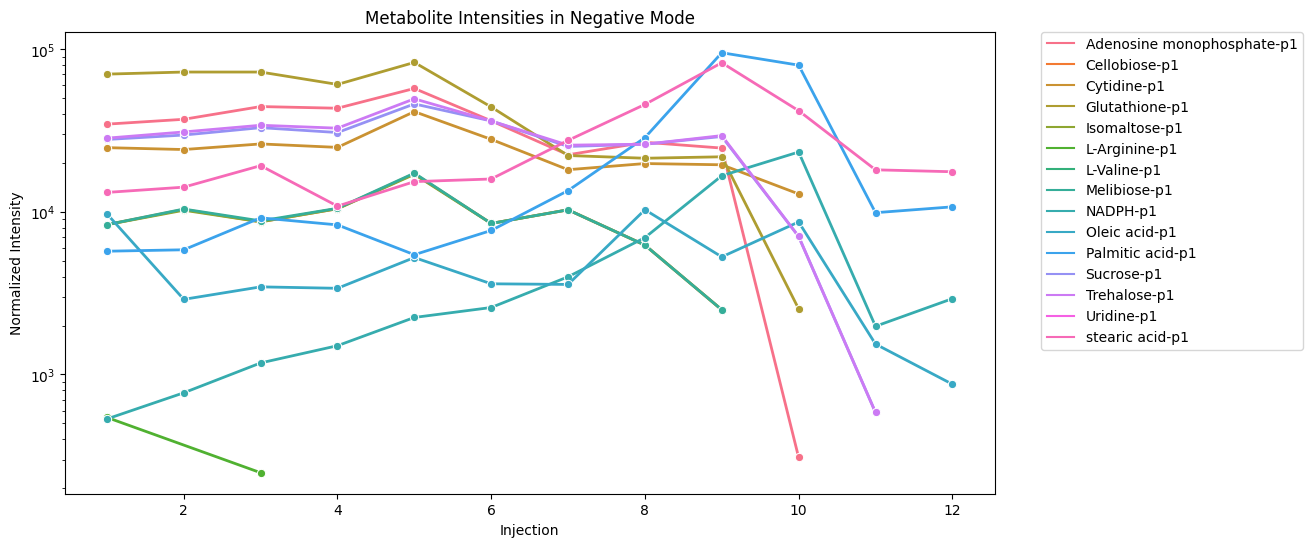

In [120]:


selected_k_means = select_metabolites(combined_no_washes, method = 'k-means', wells = positive_all_wells + negative_all_wells, k = 10)
_ = plot_normalized_intensities(positive_no_washes, positive_all_wells, selected_k_means, mode="Positive", normalize_max=False)
_ = plot_normalized_intensities(negative_no_washes, negative_all_wells, selected_k_means, mode="Negative", normalize_max=False)


In [54]:
heatmap_data

Mode                                 Negative                           \
Replicate Name                     05-neg-B12 06-neg-B11    07-neg-B10   
Molecule Name                                                            
(2)-Methylglutaric acid-p1           0.000000        0.0      0.000000   
(R)-Mevalonic acid-p1                0.000000        0.0      0.000000   
(R)-Pantothenic acid-p1              0.000000        0.0      0.000000   
2'-Deoxyadenosine-p1                 0.000000        0.0      0.000000   
2'-Deoxyadenosine-p2                 0.000000        0.0      0.000000   
...                                       ...        ...           ...   
palmitoleic acid-p1                  0.000000        0.0      0.000000   
stearic acid-p1                  26006.159962    20067.0  26463.697582   
thiamine(1+) diphosphate(1-)-p1      0.000000        0.0      0.000000   
tryptophol-p1                        0.000000        0.0      0.000000   
xanthosine-p1                        0.000000        0.0      0.000000   

Mode                                                                    \
Replicate Name                       08-neg-B9     09-neg-B8 10-neg-B7   
Molecule Name                                                            
(2)-Methylglutaric acid-p1            0.000000      0.000000       0.0   
(R)-Mevalonic acid-p1                 0.000000      0.000000       0.0   
(R)-Pantothenic acid-p1               0.000000      0.000000       0.0   
2'-Deoxyadenosine-p1                  0.000000      0.000000       0.0   
2'-Deoxyadenosine-p2                  0.000000      0.000000       0.0   
...                                        ...           ...       ...   
palmitoleic acid-p1                   0.000000      0.000000       0.0   
stearic acid-p1                  176426.469245  71608.521477       0.0   
thiamine(1+) diphosphate(1-)-p1       0.000000      0.000000       0.0   
tryptophol-p1                         0.000000      0.000000       0.0   
xanthosine-p1                         0.000000      0.000000       0.0   

Mode                                                                       \
Replicate Name                      11-neg-B6     12-neg-B5     13-neg-B4   
Molecule Name                                                               
(2)-Methylglutaric acid-p1           0.000000      0.000000      0.000000   
(R)-Mevalonic acid-p1                0.000000      0.000000      0.000000   
(R)-Pantothenic acid-p1              0.000000      0.000000      0.000000   
2'-Deoxyadenosine-p1                 0.000000      0.000000      0.000000   
2'-Deoxyadenosine-p2                 0.000000      0.000000      0.000000   
...                                       ...           ...           ...   
palmitoleic acid-p1                  0.000000      0.000000      0.000000   
stearic acid-p1                  26863.766146  29097.826303  11669.012508   
thiamine(1+) diphosphate(1-)-p1      0.000000      0.000000      0.000000   
tryptophol-p1                        0.000000      0.000000      0.000000   
xanthosine-p1                        0.000000      0.000000      0.000000   

Mode                                           ...     Positive               \
Replicate Name                      14-neg-B3  ...    70-pos-E3    71-pos-E4   
Molecule Name                                  ...                             
(2)-Methylglutaric acid-p1           0.000000  ...     0.000000     0.000000   
(R)-Mevalonic acid-p1                0.000000  ...     0.000000     0.000000   
(R)-Pantothenic acid-p1              0.000000  ...     0.000000     0.000000   
2'-Deoxyadenosine-p1                 0.000000  ...     0.000000     0.000000   
2'-Deoxyadenosine-p2                 0.000000  ...  4593.399672  4061.493545   
...                                       ...  ...          ...          ...   
palmitoleic acid-p1                  0.000000  ...     0.000000     0.000000   
stearic acid-p1                  26764.243453  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


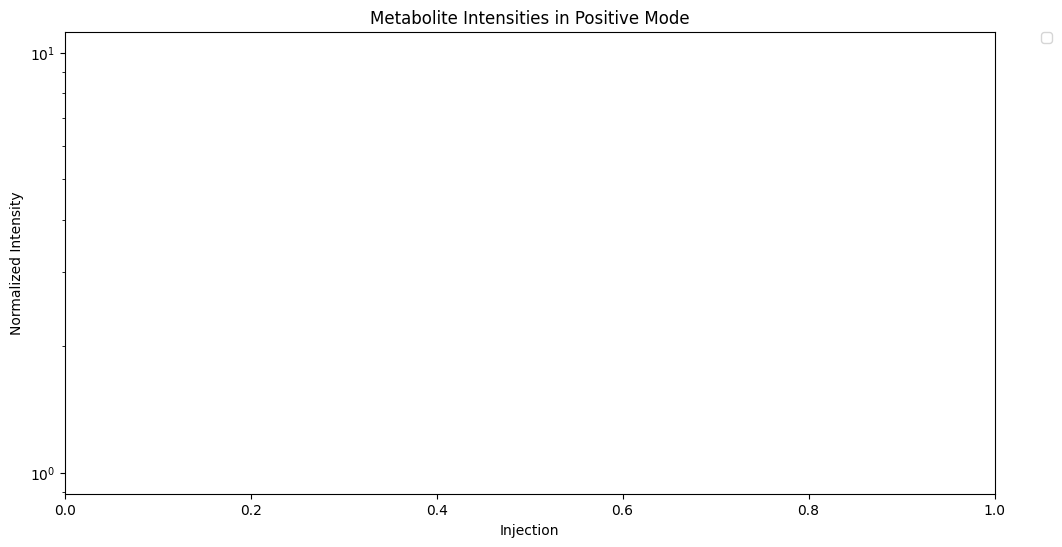

In [12]:
import numpy as np

# # # Define the lists of well names for positive and negative mode injections
# # wells = [f"{i}" for i in range(1, 13)]
# # # replicate_prefixes_positive = ["A", "C", "E"]
# # # replicate_prefixes_negative = ["B", "D", "F"]
# # replicate_prefixes_positive = ["A"]
# # replicate_prefixes_negative = ["B"]

target_metabolites = ['Glutathione-p1', 'L-Arginine-p1']
positive_all_wells = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
negative_all_wells = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']
positive_wells = ['A8', 'A9', 'A10', 'A11']
wells = positive_wells
data = positive_no_washes


data["Well"] = data["Replicate Name"].str.split('-').str[-1]
data['Injection'] = data["Well"].str.extract('(\d+)', expand=False).astype(int)
data = data[data['Well'].isin(wells)].copy()
data2 = data.groupby(['Molecule Name', 'Mode', 'Injection']).agg({'Normalized_Area' : 'mean'}).reset_index()
dp = data2.pivot_table(index="Injection", columns="Molecule Name", values="Normalized_Area").reset_index().fillna(value = 0.0)
dp_corr = dp.drop(labels = ["Injection"], axis = 1).corr()
dp_corr['mean'] = dp_corr.mean()
dp_corr = dp_corr[target_metabolites + ['mean']].sort_values(by = 'mean', ascending = False)
dfga = pd.DataFrame({"Molecule Name" : ["Glutathione-p1"]})
_ = plot_normalized_intensities(positive_no_washes, positive_all_wells, 
                            pd.concat([pd.DataFrame({"Molecule Name" : dp_corr.index[0 : 15]}), dfga]), mode="Positive", normalize_max=False)
# .loc[target_metabolites, metabolite].mean()
# dp

In [13]:
# heatmap_data = combined_no_washes.pivot_table(index='Molecule Name', columns=['Mode', 'Replicate Name'], values='Normalized_Area')
# heatmap_data = heatmap_data.fillna(value = 0.0)

heatmap_data = combined_no_washes.pivot_table(index='Molecule Name', columns=['Mode', 'Replicate Name'], values='Normalized_Area')
heatmap_data = heatmap_data.fillna(value = 0.0)

In [14]:
# # Create the clustered heatmap
# sns.clustermap(heatmap_data, cmap="coolwarm", figsize=(15, 15), col_cluster=True, row_cluster=True)

# # Show the plot
# plt.show()

The optimal number of clusters (elbow point) is: 4


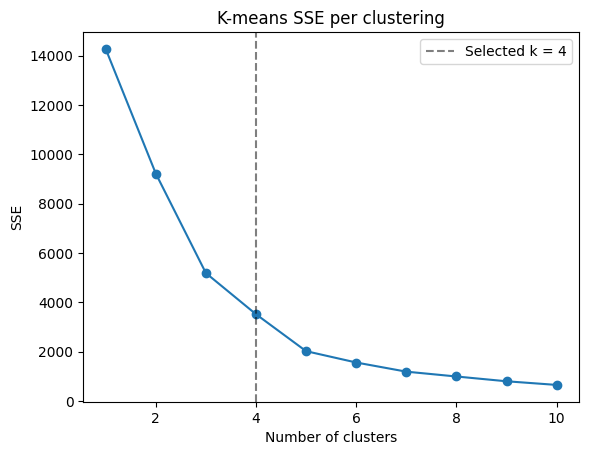

/Users/gkreder/opt/miniconda3/envs/MetabM1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(heatmap_data)


# Find the optimal number of clusters using the elbow method
sse = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Find the elbow point
knee_locator = KneeLocator(range(1, len(sse) + 1), sse, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"The optimal number of clusters (elbow point) is: {optimal_k}")

# Plot the elbow curve
plt.plot(cluster_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('K-means SSE per clustering')
plt.axvline(x = optimal_k, linestyle = '--', color = 'k', alpha = 0.5, label = f'Selected k = {optimal_k}')
plt.legend()
plt.show()


# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the original heatmap_data DataFrame
heatmap_data_clustered = heatmap_data.copy()
heatmap_data_clustered["Cluster"] = clusters

# Create a DataFrame with the molecule names and their corresponding cluster labels
metabolite_clusters = pd.DataFrame({'Molecule Name': heatmap_data_clustered.index, 'Cluster': heatmap_data_clustered['Cluster']}).reset_index(drop = True)

drop_cluster_number = metabolite_clusters.groupby('Cluster').size().sort_values(ascending=False).index[0]
found_metabolites = metabolite_clusters[metabolite_clusters['Cluster'] != drop_cluster_number]['Molecule Name'].values




array(['Adenosine monophosphate-p1', 'Cytidine-p1', 'Glutathione-p1',
       'Palmitic acid-p1', 'Sucrose-p1', 'Trehalose-p1', 'Uridine-p1',
       'stearic acid-p1'], dtype=object)

In [17]:
# Create a DataFrame with the molecule names and their corresponding cluster labels
metabolite_clusters = pd.DataFrame({'Molecule Name': heatmap_data_clustered.index, 'Cluster': heatmap_data_clustered['Cluster']}).reset_index(drop = True)

# Display the metabolites in each cluster as a table
for cluster_num in range(n_clusters):
    display(metabolite_clusters[metabolite_clusters['Cluster'] == cluster_num].sort_values(by='Molecule Name'))


,Molecule Name,Cluster
0,(2)-Methylglutaric acid-p1,0
1,(R)-Mevalonic acid-p1,0
2,(R)-Pantothenic acid-p1,0
3,2'-Deoxyadenosine-p1,0
4,2'-Deoxyadenosine-p2,0
...,...,...
177,naphthalene-p1,0
178,palmitoleic acid-p1,0
180,thiamine(1+) diphosphate(1-)-p1,0
181,tryptophol-p1,0


,Molecule Name,Cluster
164,Uridine-p1,1


,Molecule Name,Cluster
27,Adenosine monophosphate-p1,2
47,Cytidine-p1,2
66,Glutathione-p1,2
150,Sucrose-p1,2
156,Trehalose-p1,2


,Molecule Name,Cluster
132,Palmitic acid-p1,3
179,stearic acid-p1,3


,Molecule Name,Cluster
81,L-Acetylcarnitine-p1,4
82,L-Arginine-p1,4


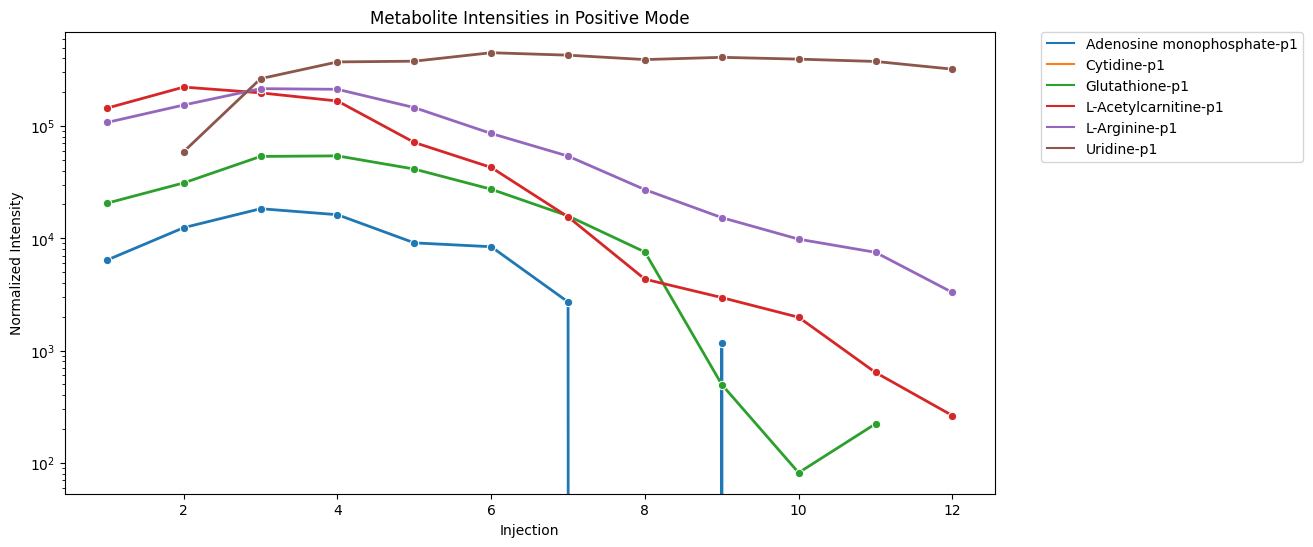

In [358]:
_ = plot_normalized_intensities(positive_no_washes, positive_all_wells, 
                            metabolite_clusters[metabolite_clusters['Cluster'] > 0], mode="Positive", normalize_max=False)

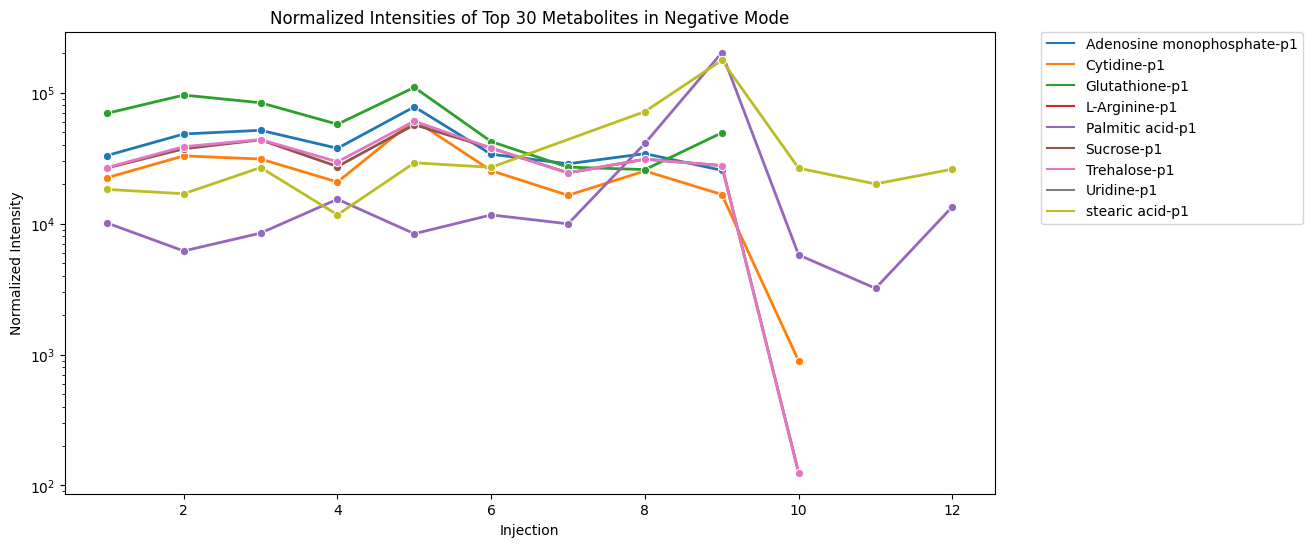

In [345]:
_ = plot_normalized_intensities(negative_no_washes, negative_all_wells, 
                            metabolite_clusters[metabolite_clusters['Cluster'] > 0], mode="Negative", normalize_max=False)

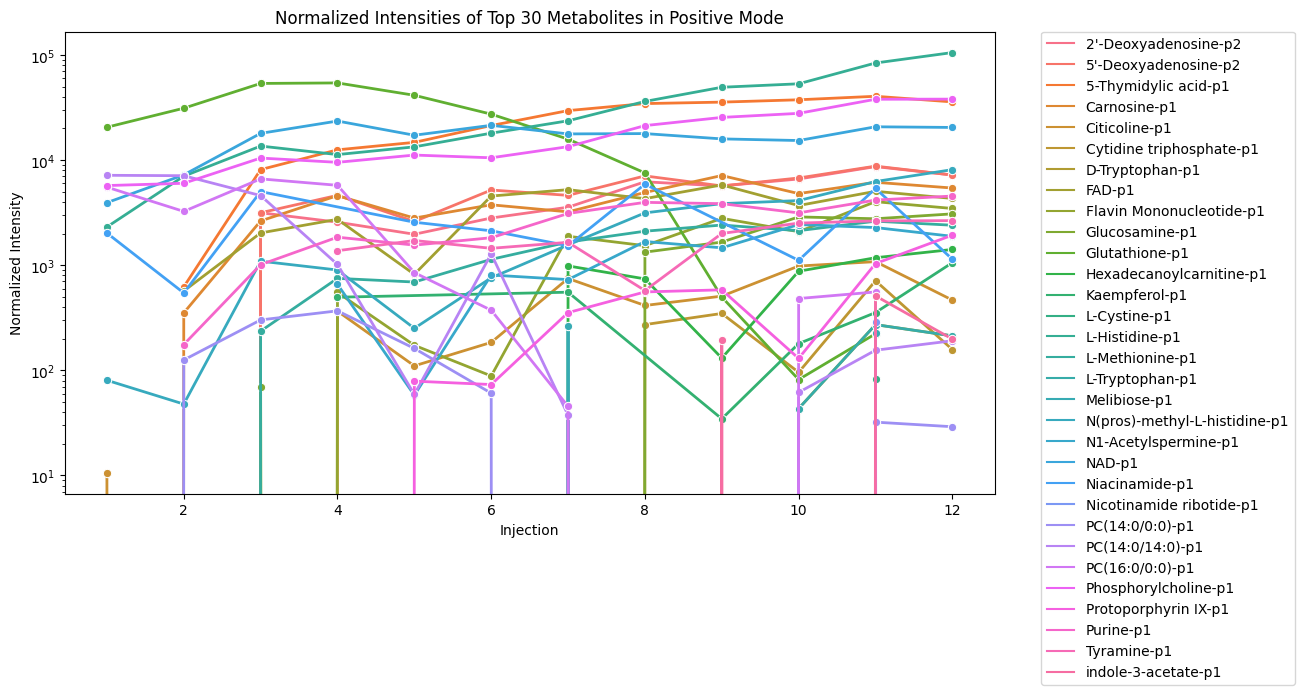

In [352]:
positive_all_wells = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
negative_all_wells = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']
positive_wells = ['A8', 'A9', 'A10', 'A11']
wells = positive_wells
data = positive_no_washes


data["Well"] = data["Replicate Name"].str.split('-').str[-1]
data['Injection'] = data["Well"].str.extract('(\d+)', expand=False).astype(int)
data = data[data['Well'].isin(wells)].copy()
data2 = data.groupby(['Molecule Name', 'Mode', 'Injection']).agg({'Normalized_Area' : 'mean'}).reset_index()
dp = data2.pivot_table(index="Injection", columns="Molecule Name", values="Normalized_Area").reset_index().fillna(value = 0.0)
dp_corr = dp.drop(labels = ["Injection"], axis = 1).corr()
dp_corr['mean'] = dp_corr.mean()
dp_corr = dp_corr[target_metabolites + ['mean']].sort_values(by = 'mean', ascending = False)
dfga = pd.DataFrame({"Molecule Name" : ["Glutathione-p1"]})
_ = plot_normalized_intensities(positive_no_washes, positive_all_wells, 
                            pd.concat([pd.DataFrame({"Molecule Name" : dp_corr.index[0 : 30]}), dfga]), mode="Positive", normalize_max=False)
# .loc[target_metabolites, metabolite].mean()
# dp

In [348]:
metabolite_clusters[metabolite_clusters["Cluster"] > 0]

,Molecule Name,Cluster
27,Adenosine monophosphate-p1,2
47,Cytidine-p1,2
66,Glutathione-p1,2
81,L-Acetylcarnitine-p1,4
82,L-Arginine-p1,4
132,Palmitic acid-p1,3
150,Sucrose-p1,2
156,Trehalose-p1,2
164,Uridine-p1,1
179,stearic acid-p1,3


In [351]:
metabolite_clusters[metabolite_clusters['Molecule Name'] == "L-Histidine-p1"]

,Molecule Name,Cluster
87,L-Histidine-p1,0
